# RNA-seq Stability Data Processing Pipeline

## Overview
This notebook processes STAR alignment output to generate count matrices for stability analysis. It processes multiple time points of differentiation experiments, combines them with reproducibility data, and performs initial quality control and correlation analyses.

## Pipeline Workflow
1. **Gene Annotation Setup**: Load GTF file and create Ensembl ID to gene symbol mapping
2. **Count Matrix Generation**: Process STAR ReadsPerGene output files from multiple experiments
3. **Data Integration**: Combine stability time-course data with reproducibility experiments
4. **Quality Control**: Generate correlation matrices and cluster heatmaps
5. **Data Export**: Save processed count matrices and metadata for downstream analysis

## Input Requirements
- STAR alignment output files (`*_STAR_ReadsPerGene.out.tab`) in `10.MAPPING/` directories
- GTF annotation file for gene symbol mapping
- Existing reproducibility data files (if integration is needed)

## Output Structure
```
bulk/
├── stability_timepoints.tsv              # Count matrix (stability experiments only)
├── stability_timepoints_meta.tsv         # Metadata for stability experiments
├── stability_timepoints_wSC.tsv          # Combined count matrix (stability + reproducibility)
├── stability_timepoints_meta_wSC.tsv     # Combined metadata
└── reproducibility_genotypes_wSC.tsv     # Reproducibility data (input)

stability_plots/
└── sample_*_timepoints_corr_variablegenes.png  # QC correlation plots
```

## Key Processing Steps
- Parses STAR gene count files and maps Ensembl IDs to gene symbols
- Combines multiple samples into unified count matrix
- Generates CPM (Counts Per Million) normalized data
- Creates correlation heatmaps for quality assessment
- Identifies most variable genes for downstream analysis

## Dependencies
- pandas, numpy (data processing)
- seaborn, matplotlib (visualization)
- re (regular expressions for sample parsing)

## Configuration and Setup

In [ ]:
# =============================================================================
# CONFIGURATION AND IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration parameters
GTF_FILE_PATH = "/links/groups/treutlein/USERS/jjans/resources/genomes/hsapiens/Homo_sapiens.GRCh38.111.chr.gtf"
OUTPUT_DIR = "bulk"
PLOT_DIR = "stability_plots"
REPRODUCIBILITY_FILE = "bulk/reproducibility_genotypes_wSC.tsv"
REPRODUCIBILITY_META_FILE = "bulk/reproducibility_genotypes_wSC_meta.tsv"

# Analysis parameters
N_VARIABLE_GENES = 1000
CPM_SCALING = 1e6
CORR_HEATMAP_VMIN = 0.92
CORR_HEATMAP_VMAX = 1.0

# Selected reproducibility experiments to include
SELECTED_REPRODUCIBILITY_EXPS = [
    'p1_D4', 'p1_D8', 'p1_D10', 'p1_B4', 'p1_B8', 'p1_B10',
    'p3_C2', 'p3_F2', 'p3_D1', 'p3_F4', 'p3_G1', 'p3_G10'
]

# Create output directories
Path(OUTPUT_DIR).mkdir(exist_ok=True)
Path(PLOT_DIR).mkdir(exist_ok=True)

# Set plotting parameters
plt.style.use('default')
sns.set_palette("husl")

print("Configuration loaded successfully:")
print(f"  GTF file: {GTF_FILE_PATH}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Plot directory: {PLOT_DIR}")
print(f"  Variable genes to analyze: {N_VARIABLE_GENES}")
print(f"  Reproducibility experiments to include: {len(SELECTED_REPRODUCIBILITY_EXPS)}")

## 1. Gene Annotation Setup

In [ ]:
gtf_file_path = "/links/groups/treutlein/USERS/jjans/resources/genomes/hsapiens/Homo_sapiens.GRCh38.111.chr.gtf"

def get_ensembl_to_symbol_mapping(gtf_file_path):
    """
    Create Ensembl ID to gene symbol mapping from GTF file.
    
    Parameters:
    -----------
    gtf_file_path : str
        Path to the GTF annotation file
        
    Returns:
    --------
    dict
        Dictionary mapping Ensembl IDs to gene symbols
    """
    try:
        with open(gtf_file_path, 'r') as f:
            gtf_lines = f.readlines()
        
        print(f"✓ Loaded GTF file with {len(gtf_lines)} lines")
        
        # Filter lines: remove comments and keep only gene entries
        gtf_lines = [line for line in gtf_lines if not line.startswith('#')]
        gtf_lines = [line for line in gtf_lines if 'gene_id "' in line and 'gene_name "' in line]
        
        if len(gtf_lines) == 0:
            raise ValueError("No valid gene entries found. Check GTF file format.")
        
        print(f"✓ Found {len(gtf_lines)} gene entries")
        
        # Extract gene_id and gene_name pairs
        gene_mappings = []
        for line in gtf_lines:
            try:
                gene_id = line.split('gene_id "')[1].split('"')[0]
                gene_name = line.split('gene_name "')[1].split('"')[0]
                gene_mappings.append((gene_id, gene_name))
            except IndexError:
                continue
        
        # Create dictionary and remove duplicates
        gtf_dict = dict(set(gene_mappings))
        
        print(f"✓ Created mapping for {len(gtf_dict)} unique genes")
        return gtf_dict
        
    except FileNotFoundError:
        raise FileNotFoundError(f"GTF file not found: {gtf_file_path}")
    except Exception as e:
        raise Exception(f"Error processing GTF file: {str(e)}")

# Create gene annotation mapping
print("Loading gene annotation mapping...")
gtf_dict = get_ensembl_to_symbol_mapping(gtf_file_path)

## 2. Count Matrix Generation from STAR Output

In [ ]:
import os

# Find stability experiment directories
stability_experiments = [x for x in os.listdir('.') if 'Stability' in x and os.path.isdir(x)]

print(f"Found {len(stability_experiments)} stability experiments:")
for exp in stability_experiments:
    print(f"  - {exp}")
    
if len(stability_experiments) == 0:
    raise ValueError("No stability experiment directories found. Make sure you're in the correct directory.")

In [ ]:
import os
import pandas as pd

def process_star_count_files(stability_experiments, gtf_dict):
    """
    Process STAR ReadsPerGene output files and combine into count matrix.
    
    Parameters:
    -----------
    stability_experiments : list
        List of stability experiment directory names
    gtf_dict : dict
        Mapping of Ensembl IDs to gene symbols
        
    Returns:
    --------
    pandas.DataFrame
        Combined count matrix with genes as rows and samples as columns
    """
    df_all = None
    processed_samples = []
    
    print("Processing STAR count files...")
    
    for stab_exp in stability_experiments:
        stab_exp_samples = os.listdir(stab_exp)
        
        for sample in stab_exp_samples:
            count_file_path = os.path.join(stab_exp, sample, "10.MAPPING", f"{sample}_STAR_ReadsPerGene.out.tab")
            
            if not os.path.exists(count_file_path):
                print(f"⚠ Warning: Count file not found for {sample}")
                continue
                
            try:
                # Read STAR count file (skip first 4 lines which are summary stats)
                df = pd.read_csv(count_file_path, sep="\t", skiprows=4, header=None)
                df.columns = ['Gene_ID', 'Unstranded', '1st_read', '2nd_read']
                
                # Map Ensembl IDs to gene symbols
                df['Gene_Symbol'] = [gtf_dict.get(gene_id, gene_id) for gene_id in df['Gene_ID']]
                df.set_index('Gene_Symbol', inplace=True)
                
                # Initialize combined dataframe with first sample
                if df_all is None:
                    df_all = pd.DataFrame(index=df.index)
                
                # Add unstranded counts to combined matrix
                df_all[sample] = df['Unstranded']
                processed_samples.append(sample)
                
                print(f"  ✓ Processed {sample}: {len(df)} genes")
                
            except Exception as e:
                print(f"  ✗ Error processing {sample}: {str(e)}")
                continue
    
    print(f"\nProcessing complete:")
    print(f"  Total samples processed: {len(processed_samples)}")
    print(f"  Total genes: {len(df_all)}")
    
    return df_all

# Process all stability experiments
df_all = process_star_count_files(stability_experiments, gtf_dict)




Stability_d21/Stability_d21_sample_9/10.MAPPING/Stability_d21_sample_9_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_4/10.MAPPING/Stability_d21_sample_4_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_5/10.MAPPING/Stability_d21_sample_5_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_10/10.MAPPING/Stability_d21_sample_10_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_7/10.MAPPING/Stability_d21_sample_7_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_6/10.MAPPING/Stability_d21_sample_6_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_1/10.MAPPING/Stability_d21_sample_1_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_12/10.MAPPING/Stability_d21_sample_12_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_3/10.MAPPING/Stability_d21_sample_3_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d21_sample_2/10.MAPPING/Stability_d21_sample_2_STAR_ReadsPerGene.out.tab
Stability_d21/Stability_d2

In [ ]:
print("Aggregating counts by gene symbol...")
print(f"Before aggregation: {df_all.shape[0]} rows")

df_all = df_all.groupby("Gene_Symbol").sum()

print(f"After aggregation: {df_all.shape[0]} rows")
print(f"Final count matrix shape: {df_all.shape}")

In [ ]:
# Export stability timepoints count matrix
stability_output_file = os.path.join(OUTPUT_DIR, "stability_timepoints.tsv")
df_all.to_csv(stability_output_file, sep="\t")
print(f"✓ Exported count matrix to: {stability_output_file}")
print(f"  Matrix dimensions: {df_all.shape}")

In [ ]:
# Generate metadata from sample names
print("Generating sample metadata...")

# Parse sample names (expected format: Stability_dX_sample_Y)
sample_info = []
for sample_name in df_all.columns:
    parts = sample_name.split('_')
    if len(parts) >= 4:
        timepoint = parts[1]  # e.g., 'd10'
        sample_id = parts[3]  # e.g., 'sample_1'
        timepoint_int = int(re.sub(r'[^0-9]', '', timepoint))  # Extract numeric part
        
        sample_info.append({
            'sample_name': sample_name,
            'timepoint': timepoint,
            'sample_id': sample_id,
            'timepoint_int': timepoint_int,
            'genotype': '409B2',  # Default genotype for stability experiments
            'replicate': 1
        })
    else:
        print(f"⚠ Warning: Unexpected sample name format: {sample_name}")

# Create metadata dataframe
df_meta = pd.DataFrame(sample_info)
df_meta.set_index('sample_name', inplace=True)

print(f"✓ Generated metadata for {len(df_meta)} samples")
print("Timepoints found:", sorted(df_meta['timepoint'].unique()))

In [ ]:
# Export stability metadata
stability_meta_file = os.path.join(OUTPUT_DIR, "stability_timepoints_meta.tsv")
df_meta.to_csv(stability_meta_file, sep="\t")
print(f"✓ Exported metadata to: {stability_meta_file}")

## 3. Data Integration with Reproducibility Experiments

In [ ]:
import os
import pandas as pd

# Define file paths
REPRODUCIBILITY_FILE = "bulk/reproducibility_genotypes_wSC.tsv"
REPRODUCIBILITY_META_FILE = "bulk/reproducibility_genotypes_wSC_meta.tsv"

# Load reproducibility data if available
try:
    if os.path.exists(REPRODUCIBILITY_FILE) and os.path.exists(REPRODUCIBILITY_META_FILE):
        print("Loading reproducibility data...")
        df_repr = pd.read_csv(REPRODUCIBILITY_FILE, sep="\t", index_col=0)
        meta_repr = pd.read_csv(REPRODUCIBILITY_META_FILE, sep="\t", index_col=0)
        
        print(f"✓ Loaded reproducibility data: {df_repr.shape}")
        print(f"✓ Loaded reproducibility metadata: {meta_repr.shape}")
        
        reproducibility_available = True
    else:
        print("⚠ Reproducibility data files not found. Continuing with stability data only.")
        reproducibility_available = False
        
except Exception as e:
    print(f"⚠ Error loading reproducibility data: {str(e)}")
    print("Continuing with stability data only.")
    reproducibility_available = False

In [ ]:
# Select specific reproducibility experiments to include
if reproducibility_available:
    print(f"Selecting {len(SELECTED_REPRODUCIBILITY_EXPS)} reproducibility experiments:")
    
    # Check which experiments are available
    available_exps = [exp for exp in SELECTED_REPRODUCIBILITY_EXPS if exp in df_repr.columns]
    missing_exps = [exp for exp in SELECTED_REPRODUCIBILITY_EXPS if exp not in df_repr.columns]
    
    if missing_exps:
        print(f"⚠ Missing experiments: {missing_exps}")
    
    print(f"✓ Available experiments: {available_exps}")
    selected_parse_exps = available_exps
else:
    selected_parse_exps = []

In [ ]:
# Subset reproducibility data to selected experiments
if reproducibility_available and selected_parse_exps:
    df_repr_parse = df_repr[selected_parse_exps]
    meta_repr_parse = meta_repr.loc[selected_parse_exps]
    
    print(f"✓ Subsetted reproducibility data: {df_repr_parse.shape}")
    print(f"✓ Subsetted reproducibility metadata: {meta_repr_parse.shape}")
else:
    print("Skipping reproducibility data integration")

In [ ]:
# Merge stability and reproducibility data
if reproducibility_available and selected_parse_exps:
    print("Merging stability and reproducibility data...")
    
    # Merge count matrices (inner join to keep only common genes)
    df_all_parse = pd.merge(df_all, df_repr_parse, left_index=True, right_index=True, how='inner')
    
    print(f"✓ Merged count matrix: {df_all_parse.shape}")
    print(f"  Stability samples: {df_all.shape[1]}")
    print(f"  Reproducibility samples: {df_repr_parse.shape[1]}")
    print(f"  Common genes: {df_all_parse.shape[0]}")
else:
    df_all_parse = df_all.copy()
    print("Using stability data only")

In [ ]:
meta_repr_parse['timepoint'] = 'd10'  # Assume reproducibility samples are from day 10
meta_repr_parse['timepoint_int'] = 10

In [ ]:
# Standardize stability metadata
df_meta = df_meta.copy()
# Genotype and replicate already set during metadata generation

In [ ]:
# Merge metadata
if reproducibility_available and selected_parse_exps:
    print("Merging metadata...")
    df_meta_combined = pd.concat([df_meta, meta_repr_parse], sort=False)
    
    print(f"✓ Combined metadata: {df_meta_combined.shape}")
    print(f"  Stability samples: {len(df_meta)}")
    print(f"  Reproducibility samples: {len(meta_repr_parse)}")
else:
    df_meta_combined = df_meta.copy()
    print("Using stability metadata only")

In [ ]:
import os

# Assuming OUTPUT_DIR is defined earlier in the code
OUTPUT_DIR = "bulk"

# Export combined data
combined_count_file = os.path.join(OUTPUT_DIR, "stability_timepoints_wSC.tsv")
combined_meta_file = os.path.join(OUTPUT_DIR, "stability_timepoints_meta_wSC.tsv")

df_all_parse.to_csv(combined_count_file, sep="\t")
df_meta_combined.to_csv(combined_meta_file, sep="\t")

print(f"✓ Exported combined count matrix to: {combined_count_file}")
print(f"  Dimensions: {df_all_parse.shape}")
print(f"✓ Exported combined metadata to: {combined_meta_file}")
print(f"  Dimensions: {df_meta_combined.shape}")

## 4. Quality Control and Correlation Analysis

In [ ]:
# Check library sizes (total counts per sample)
print("Library size summary:")
library_sizes = df_all.sum().sort_values()
print(f"Median library size: {library_sizes.median():,.0f}")
print(f"Min library size: {library_sizes.min():,.0f}")
print(f"Max library size: {library_sizes.max():,.0f}")

print("\nSmallest libraries:")
print(library_sizes.head().apply(lambda x: f"{x:,.0f}"))

print("\nLargest libraries:")
print(library_sizes.tail().apply(lambda x: f"{x:,.0f}"))

Stability_d49_sample_1      993984
Stability_d42_sample_12    1080598
Stability_d42_sample_11    1181846
Stability_d35_sample_1     1285938
Stability_d21_sample_1     1305302
                            ...   
Stability_d35_sample_6     3092852
Stability_d10_sample_3     3176690
Stability_d10_sample_7     3299159
Stability_d35_sample_7     3463366
Stability_d49_sample_7     3714176
Length: 72, dtype: int64

In [ ]:
# Normalize to CPM (Counts Per Million)
print("Normalizing to CPM...")
df_all_CPM = df_all.div(df_all.sum(axis=0), axis=1) * CPM_SCALING

print(f"✓ CPM normalization complete")
print(f"  Original range: {df_all.min().min():.0f} - {df_all.max().max():.0f}")
print(f"  CPM range: {df_all_CPM.min().min():.2f} - {df_all_CPM.max().max():.2f}")

# Verify normalization
print(f"  CPM sums per sample: {df_all_CPM.sum().min():.0f} - {df_all_CPM.sum().max():.0f}")

In [ ]:
# Identify most variable genes for correlation analysis
print(f"Selecting top {N_VARIABLE_GENES} most variable genes...")

# Calculate variance across samples
gene_variance = df_all_CPM.T.var().sort_values(ascending=False)
var_genes = list(gene_variance.head(n=N_VARIABLE_GENES).index)

print(f"✓ Selected {len(var_genes)} variable genes")
print(f"  Variance range: {gene_variance.iloc[0]:.2f} - {gene_variance.iloc[N_VARIABLE_GENES-1]:.2f}")

# Show top variable genes
print("\nTop 10 most variable genes:")
print(gene_variance.head(10).round(2))

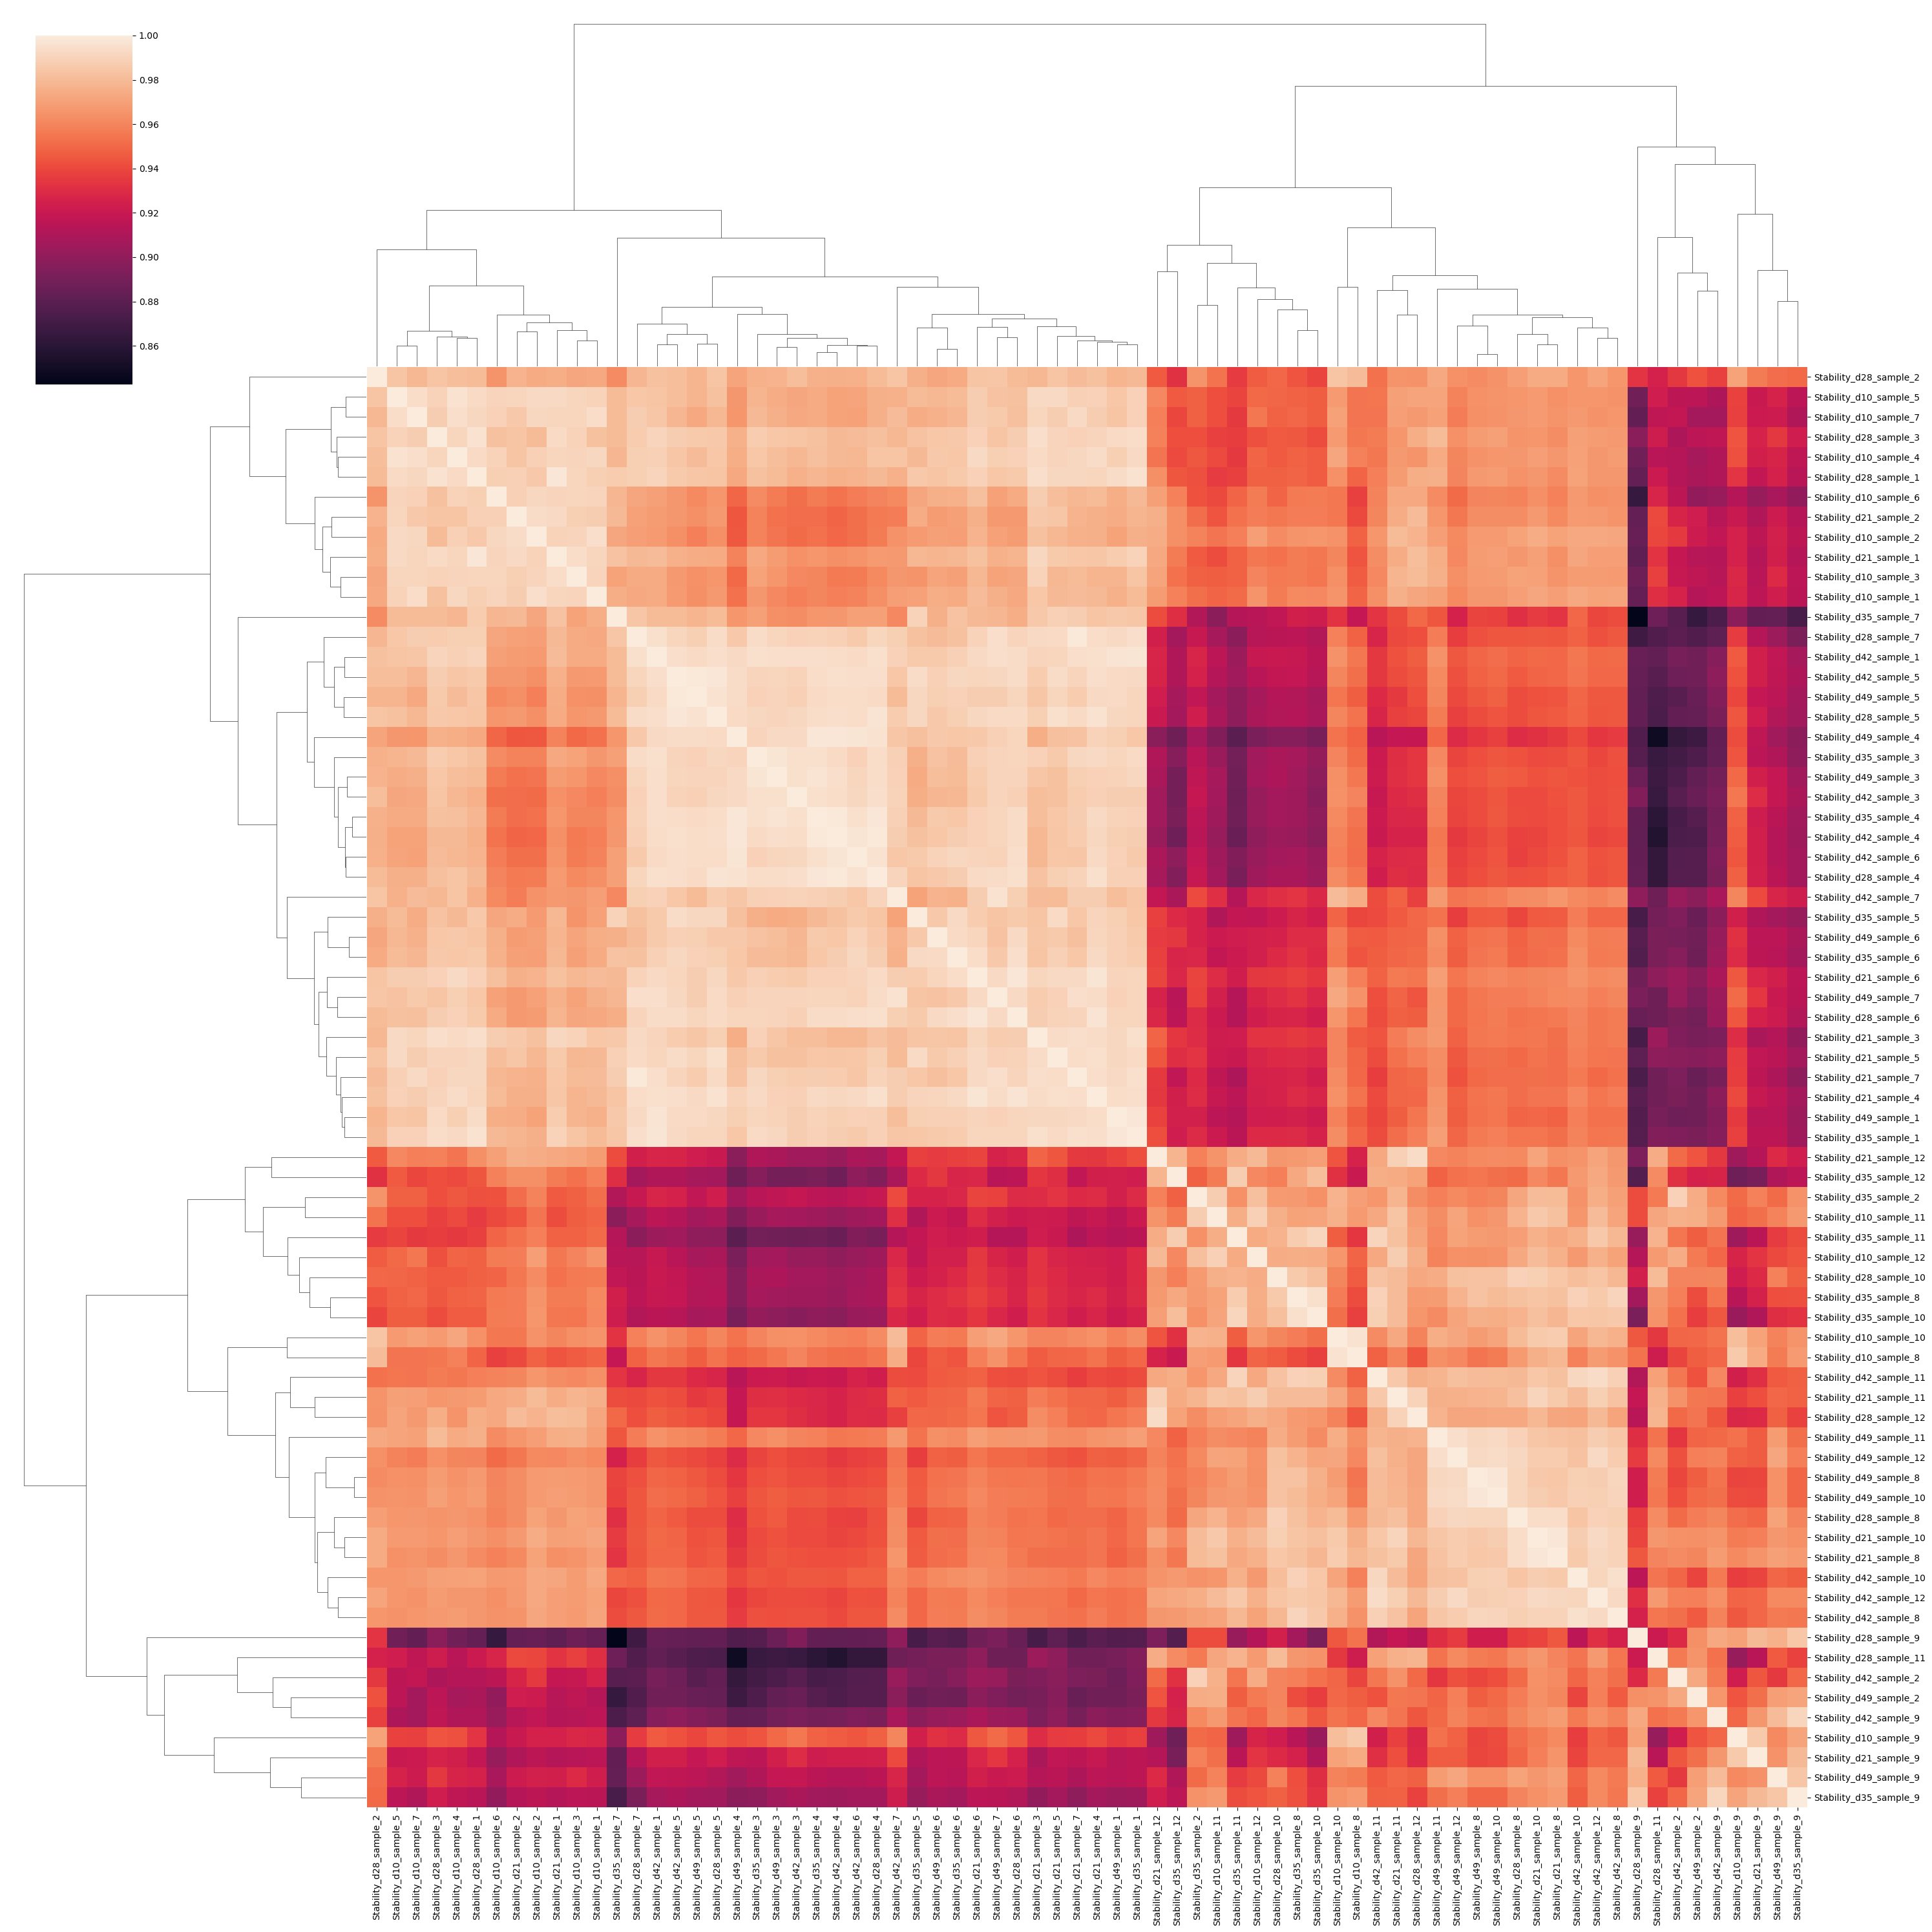

In [ ]:
# Overall correlation heatmap for all samples
print("Generating overall sample correlation heatmap...")

plt.figure(figsize=(20, 20))
correlation_matrix = df_all_CPM.loc[var_genes].corr()

sns.clustermap(
    correlation_matrix, 
    figsize=(20, 20),
    cmap='viridis',
    vmin=CORR_HEATMAP_VMIN,
    vmax=CORR_HEATMAP_VMAX,
    cbar_kws={'label': 'Pearson Correlation'}
)

plt.savefig(
    os.path.join(PLOT_DIR, "all_samples_correlation_heatmap.png"),
    dpi=300, bbox_inches='tight'
)
plt.show()
plt.close()

print(f"✓ Saved overall correlation heatmap to {PLOT_DIR}/all_samples_correlation_heatmap.png")

In [ ]:
meta = pd.DataFrame(index=df_all_CPM.columns)
import re
meta['age'] = [re.sub("Stability_","",re.sub("_sample.*","",x)) for x in meta.index]
meta['sample'] = [re.sub(".*_sample_","",x) for x in meta.index]

# Parse sample metadata for grouped analysis
print("Parsing sample metadata for visualization...")

meta_viz = pd.DataFrame(index=df_all_CPM.columns)

# Extract age/timepoint and sample info from sample names
meta_viz['timepoint'] = [re.sub("Stability_", "", re.sub("_sample.*", "", x)) for x in meta_viz.index]
meta_viz['sample_id'] = [re.sub(".*_sample_", "", x) for x in meta_viz.index]

print(f"✓ Parsed metadata for {len(meta_viz)} samples")
print("Timepoints found:", sorted(meta_viz['timepoint'].unique()))
print("Sample IDs found:", sorted(meta_viz['sample_id'].unique()))


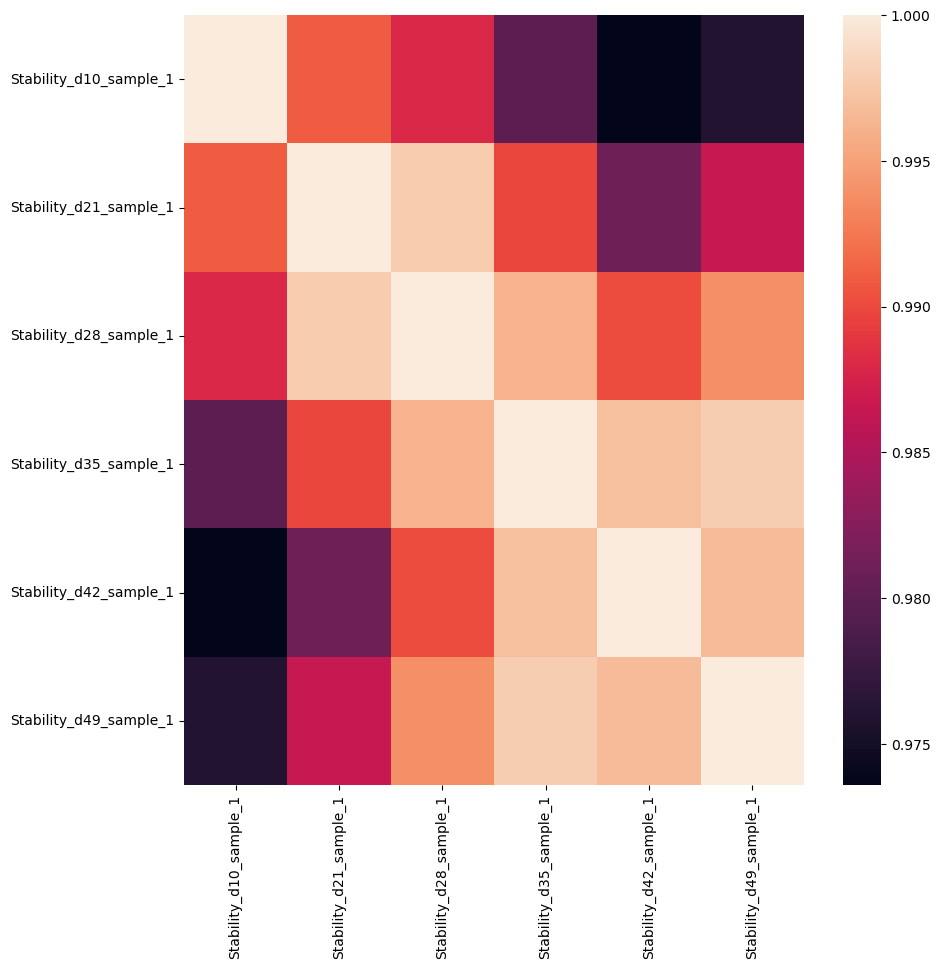

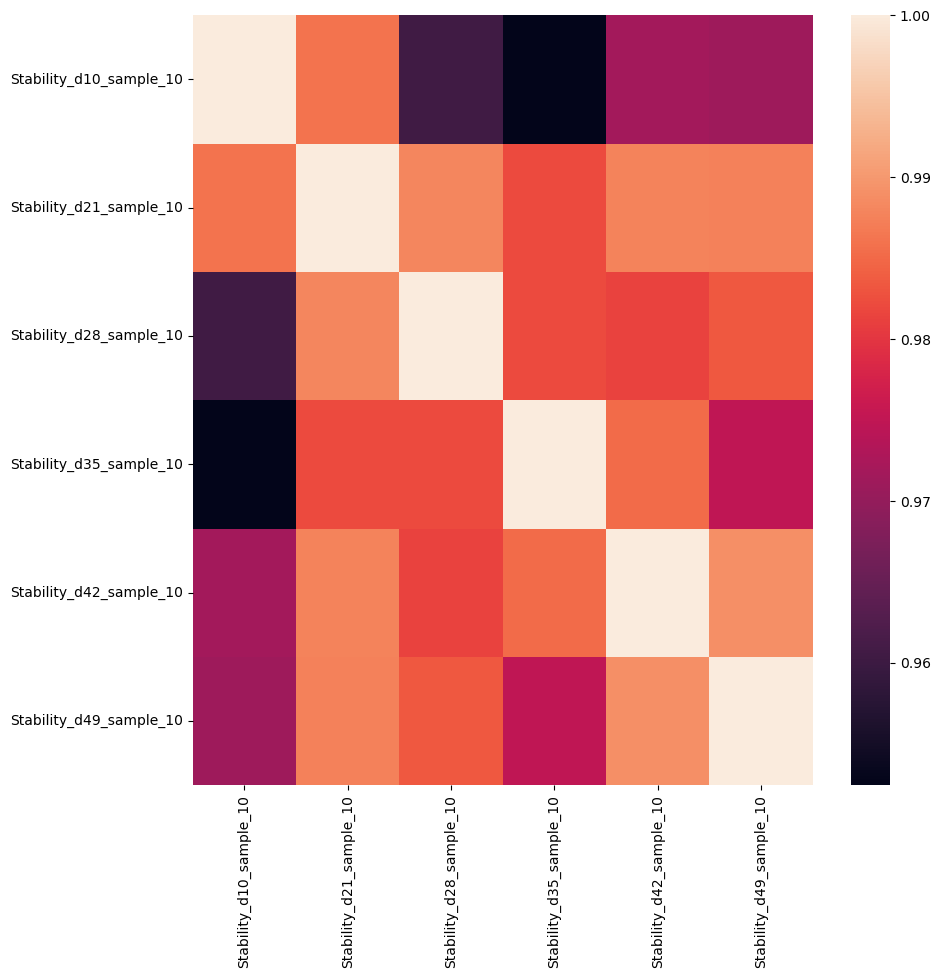

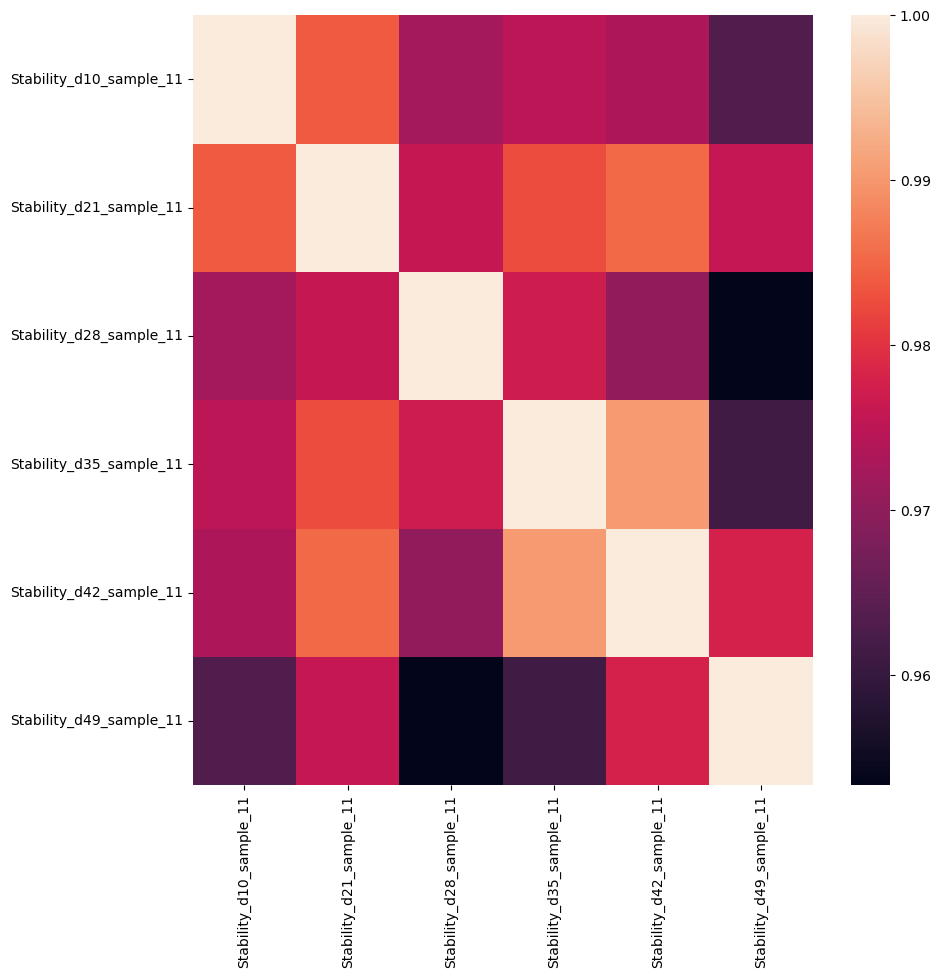

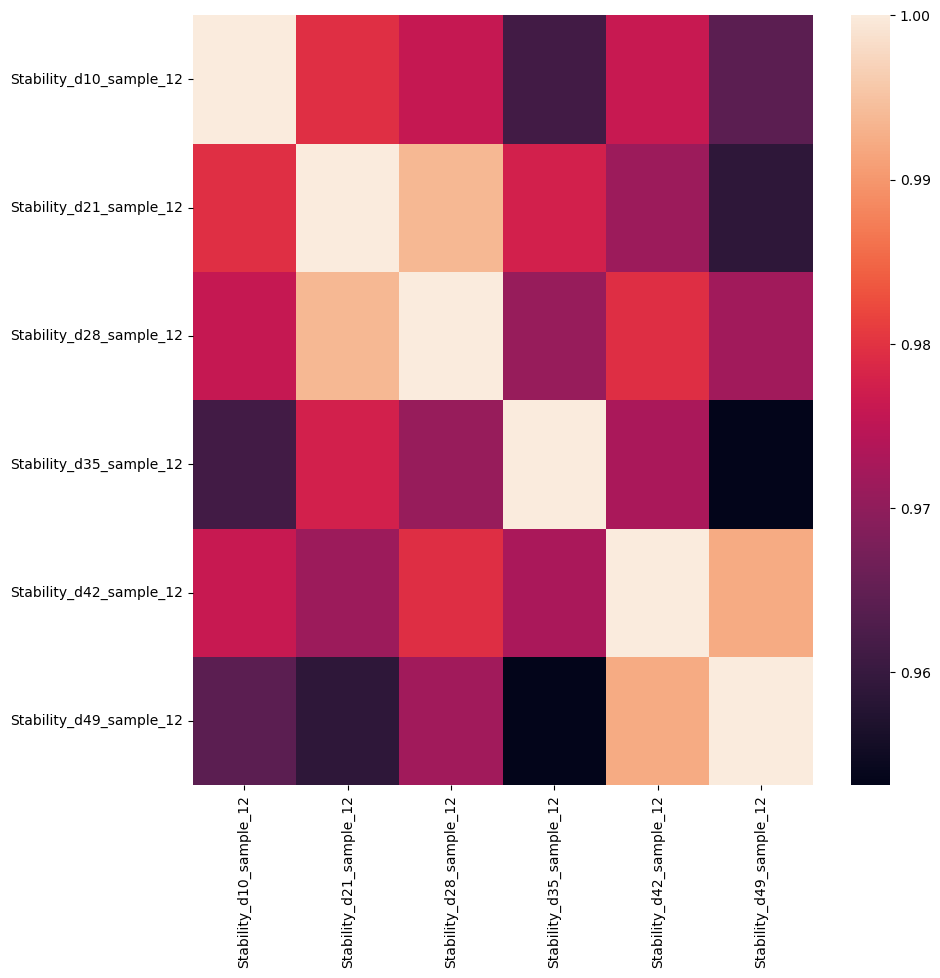

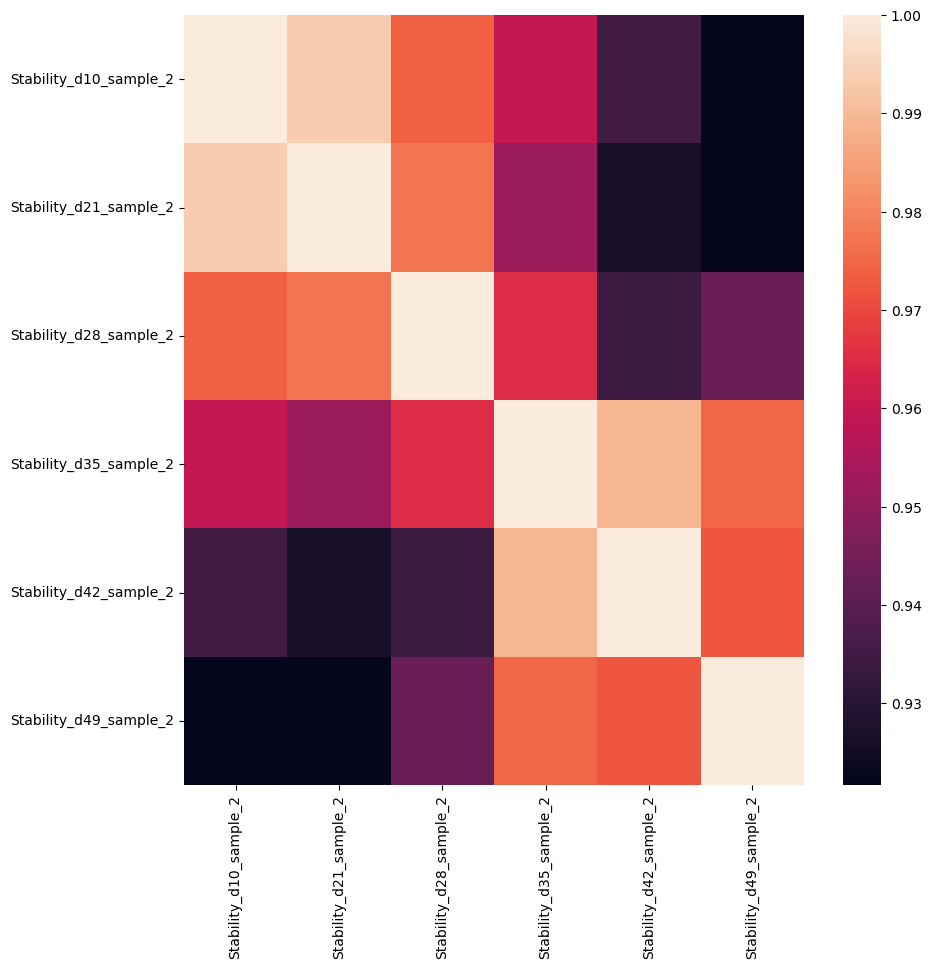

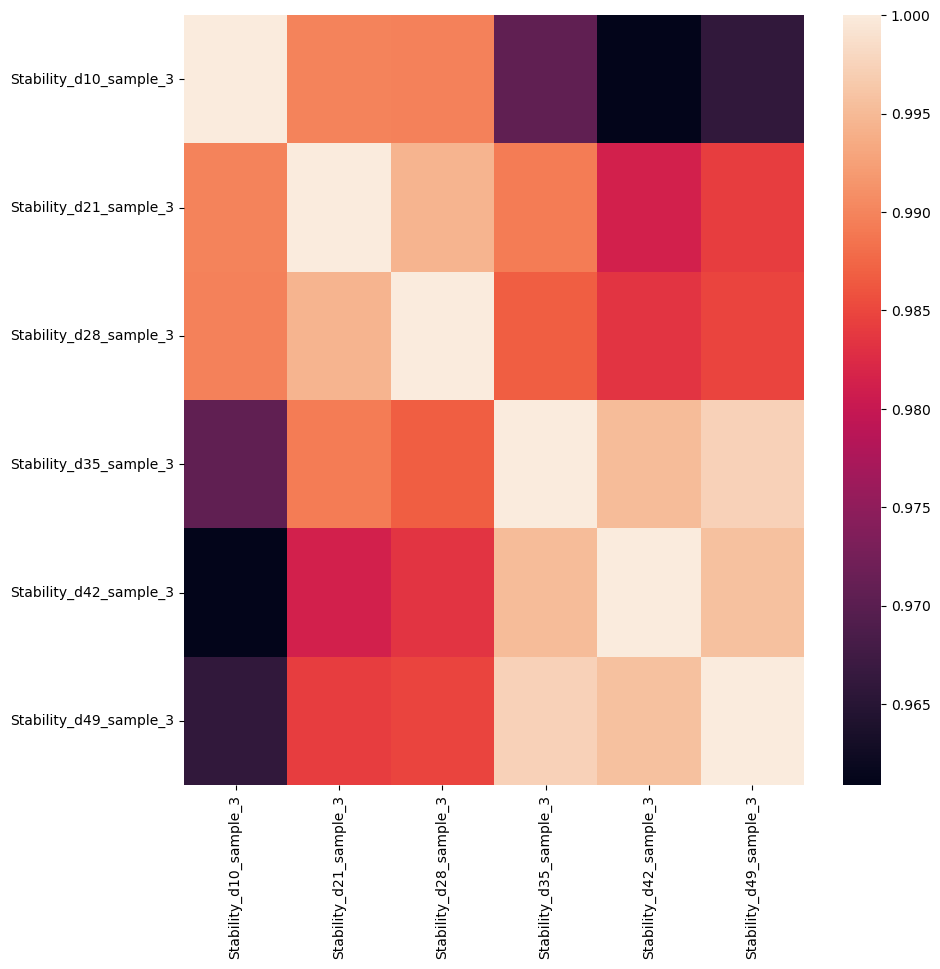

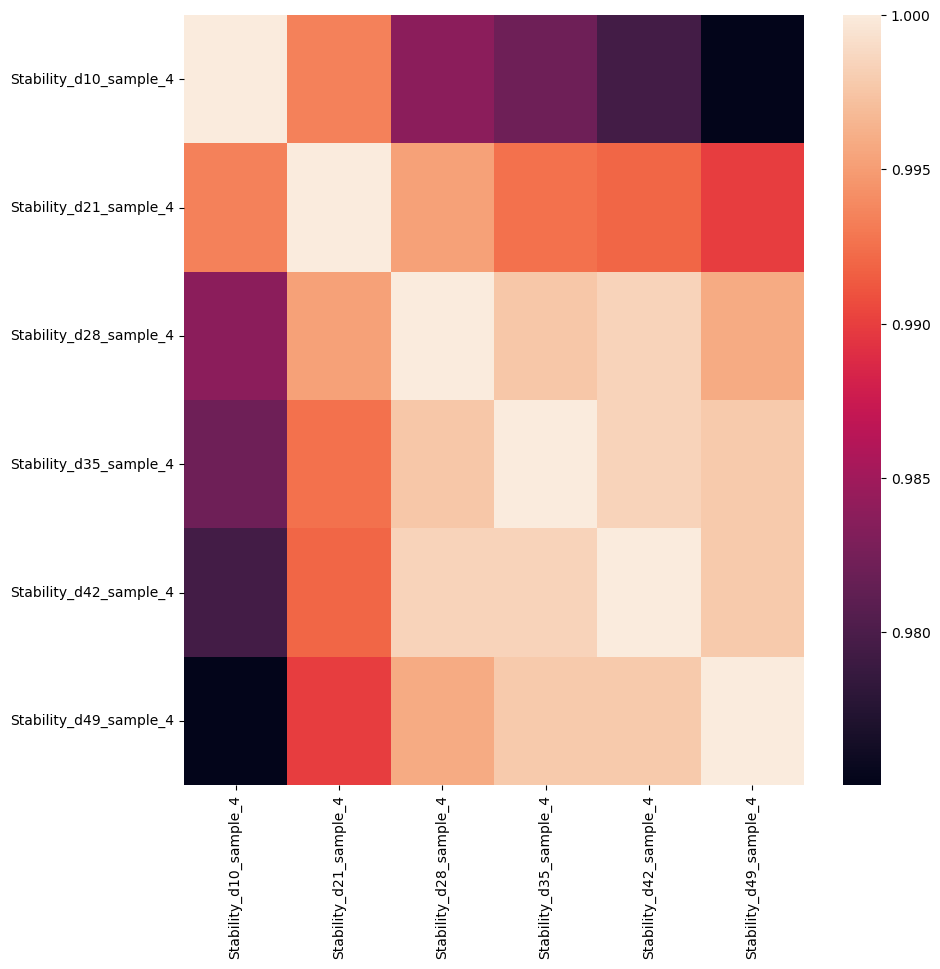

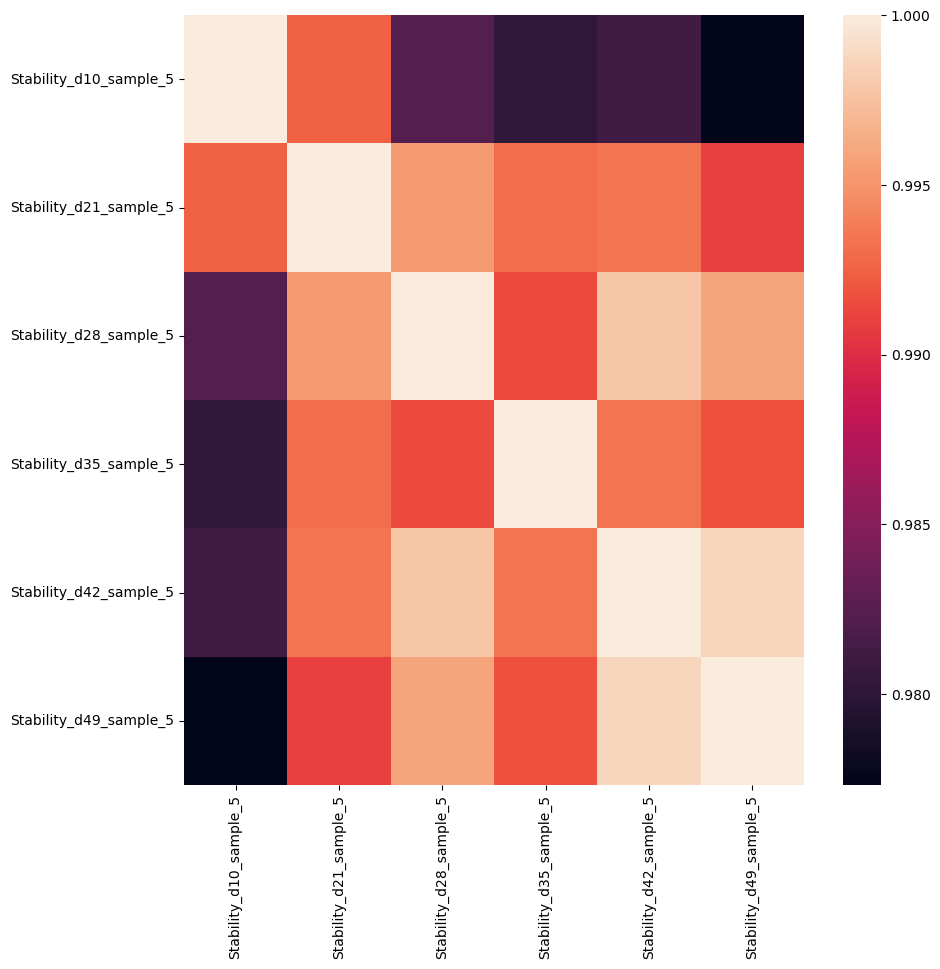

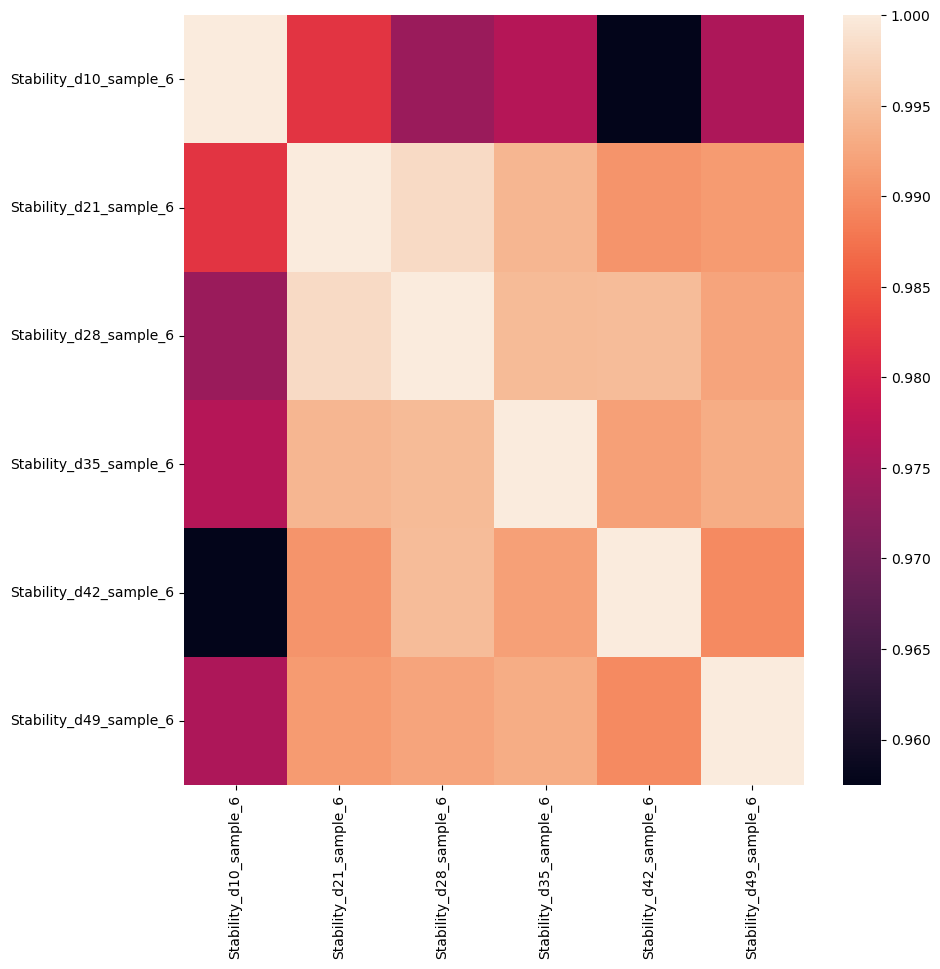

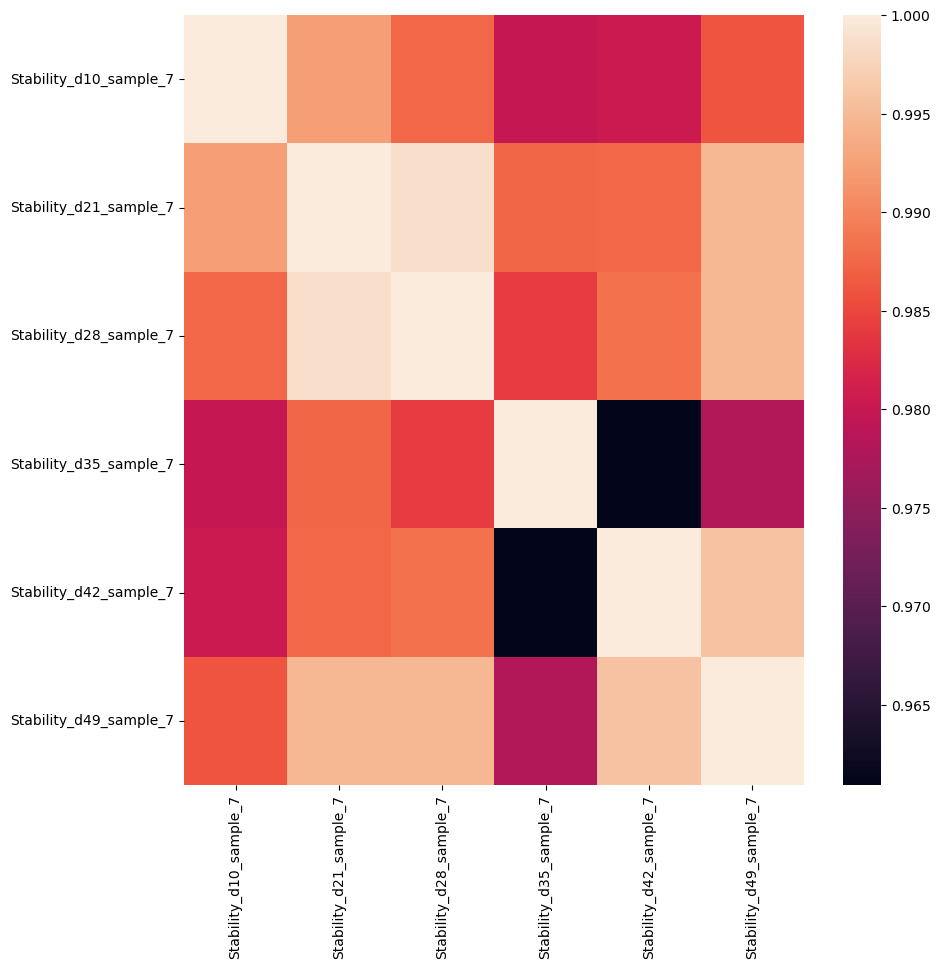

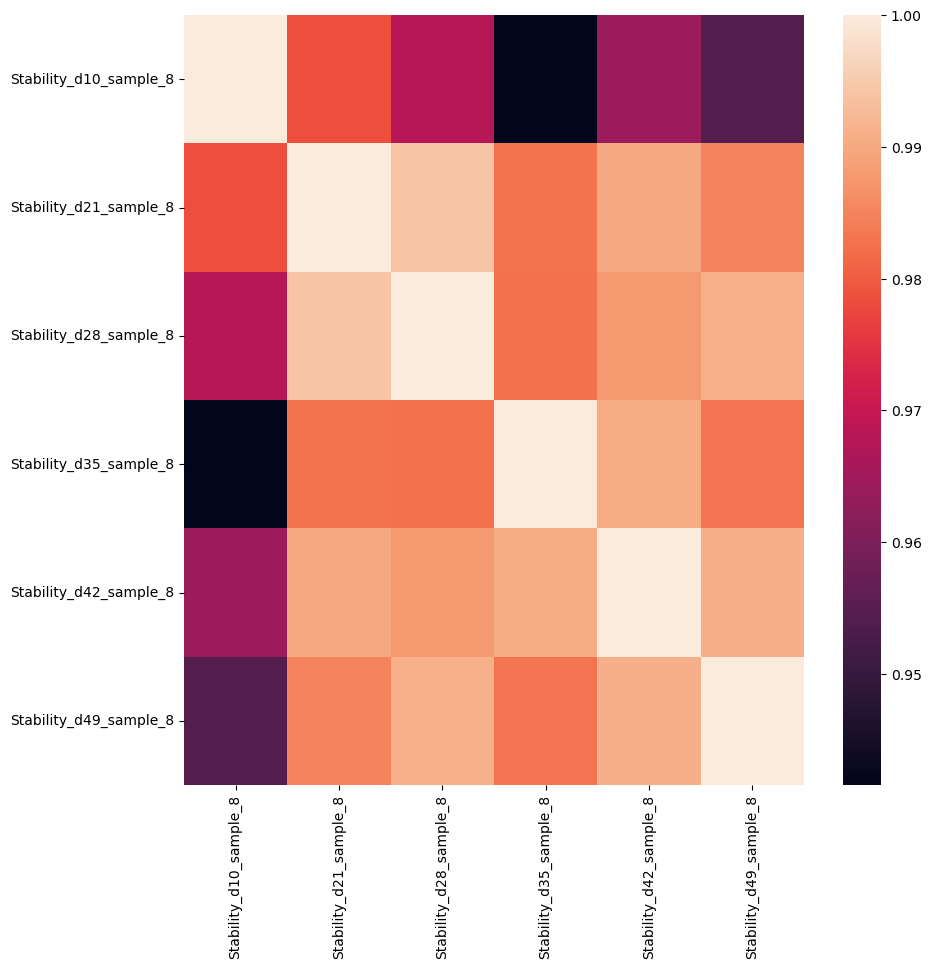

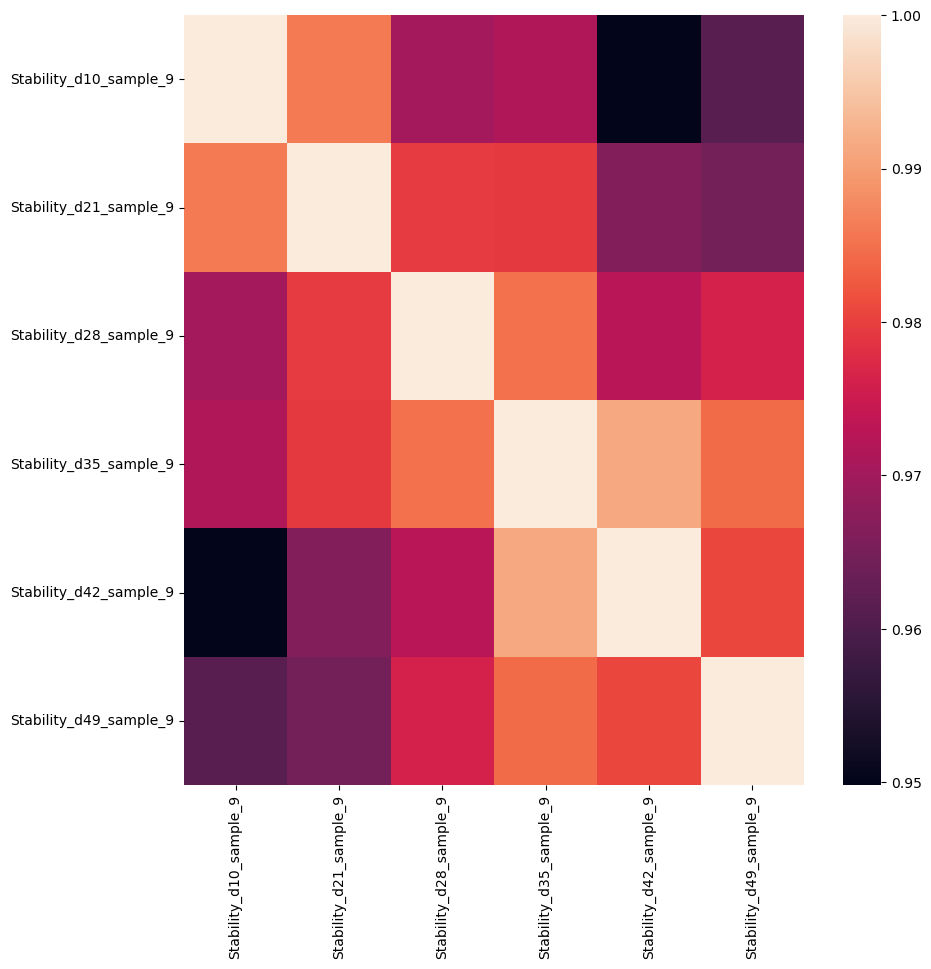

In [ ]:
# Sample-wise correlation analysis
print("Generating correlation heatmaps by sample...")

ordered_samples = []
meta_viz_sorted = meta_viz.sort_values(by=['sample_id', 'timepoint'])
correlation_mins = []

unique_samples = sorted(meta_viz['sample_id'].unique())
print(f"Analyzing {len(unique_samples)} unique samples")

for sample_id in unique_samples:
    # Get all timepoints for this sample
    sample_timepoints = meta_viz_sorted[meta_viz_sorted['sample_id'] == sample_id].index.tolist()
    
    if len(sample_timepoints) < 2:
        print(f"⚠ Skipping sample {sample_id}: only {len(sample_timepoints)} timepoint(s)")
        continue
        
    print(f"  Processing sample {sample_id}: {len(sample_timepoints)} timepoints")
    
    # Create correlation heatmap for this sample
    plt.figure(figsize=(10, 10))
    sample_corr = df_all_CPM.loc[var_genes, sample_timepoints].corr()
    
    sns.heatmap(
        sample_corr,
        vmin=CORR_HEATMAP_VMIN,
        vmax=CORR_HEATMAP_VMAX,
        cmap='viridis',
        annot=True,
        fmt='.3f',
        cbar_kws={'label': 'Pearson Correlation'}
    )
    
    plt.title(f'Sample {sample_id} Timepoint Correlations')
    plt.tight_layout()
    
    # Save individual heatmap
    sample_plot_file = os.path.join(PLOT_DIR, f"sample_{sample_id}_timepoints_corr_variablegenes.png")
    plt.savefig(sample_plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Track ordered samples and correlation statistics
    ordered_samples.extend(sample_timepoints)
    correlation_mins.append(sample_corr.min().min())

print(f"✓ Generated correlation heatmaps for {len(unique_samples)} samples")
print(f"  Minimum correlation across all samples: {min(correlation_mins):.3f}")
print(f"  Maximum correlation across all samples: {max(correlation_mins):.3f}")

0.9735775127377414
0.9524257824562231
0.9533085064017714
0.9531277221718979
0.9216863834122349
0.9608759256945191
0.9750512680694298
0.9773160758721067
0.9574841888976291
0.9609194813482748
0.9415618955302942
0.9498040766735429


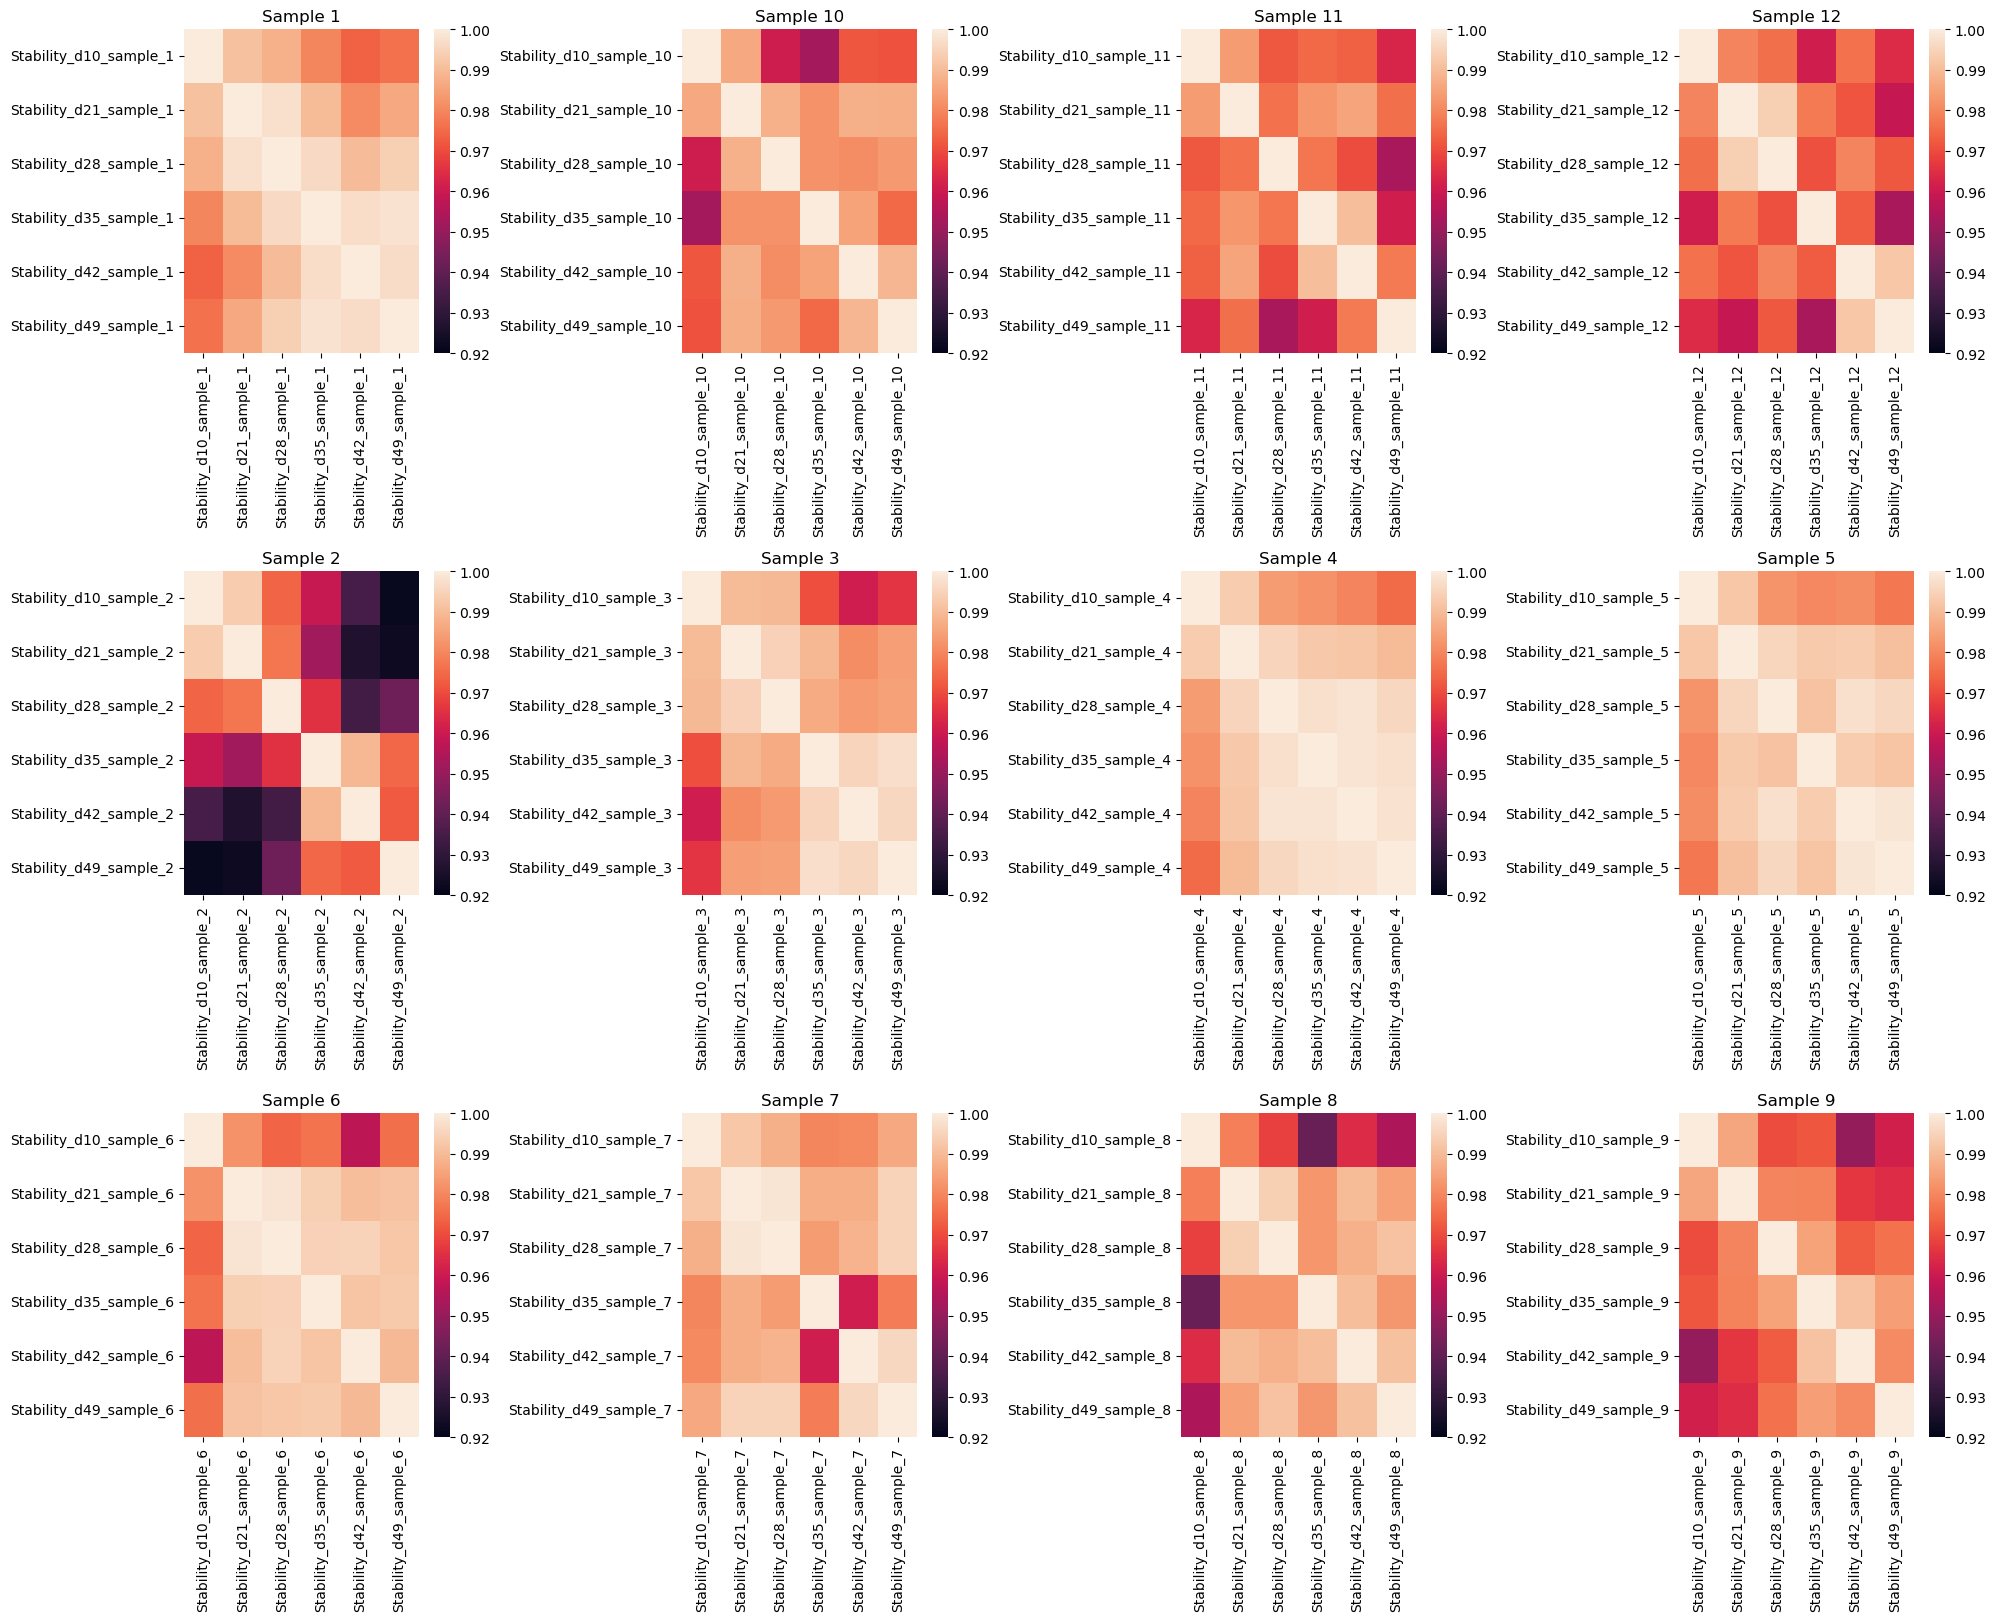

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Assuming 'meta' and 'df_all_CPM' are your DataFrame objects and 'var_genes' is your list of variable genes

ordered_samples = []
meta = meta.sort_values(by=['sample', 'age'])

# Get unique samples and determine grid size
unique_samples = sorted(list(set(meta['sample'])))
num_samples = len(unique_samples)

print("Creating grid heatmap visualization...")

if num_samples > 0:
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(4*grid_size, 4*grid_size))
    
    # Handle single subplot case
    if grid_size == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, sample_id in enumerate(unique_samples):
        sample_timepoints = meta[meta['sample'] == sample_id].index.tolist()
        
        if len(sample_timepoints) >= 2:
            # Plot correlation heatmap
            sample_corr = df_all_CPM.loc[var_genes, sample_timepoints].corr()
            
            sns.heatmap(
                sample_corr,
                ax=axes[i],
                vmin=0.92,
                vmax=1,
                cmap='viridis',
                cbar=False
            )
            
            axes[i].set_title(f'Sample {sample_id}', fontsize=10)
        else:
            axes[i].text(0.5, 0.5, f'Sample {sample_id}\n(insufficient data)', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    
    # Hide unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Sample Correlation Grid', fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Save grid plot
    grid_plot_file = os.path.join("stability_plots", "sample_correlations_grid.png")
    plt.savefig(grid_plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"✓ Saved grid heatmap to {grid_plot_file}")
else:
    print("⚠ No samples available for grid visualization")


In [ ]:
import os
import numpy as np
import pandas as pd

PLOT_DIR = "stability_plots"

# Load differential expression results (if available)
deseq2_file = os.path.join(PLOT_DIR, "deseq2_time.tsv")

if os.path.exists(deseq2_file):
    print("Loading differential expression results...")
    
    time_deseq2 = pd.read_csv(deseq2_file, sep="\t", index_col=0)
    
    # Calculate signed p-values for visualization
    time_deseq2['signed_pval'] = np.sign(time_deseq2['log2FoldChange']) * -np.log10(time_deseq2['pvalue'])
    
    print(f"✓ Loaded DESeq2 results: {time_deseq2.shape}")
    print(f"  Significant genes (p < 0.05): {(time_deseq2['pvalue'] < 0.05).sum()}")
    print(f"  Upregulated genes (logFC > 0): {(time_deseq2['log2FoldChange'] > 0).sum()}")
    print(f"  Downregulated genes (logFC < 0): {(time_deseq2['log2FoldChange'] < 0).sum()}")
    
    deseq2_available = True
else:
    print(f"⚠ DESeq2 results file not found: {deseq2_file}")
    print("Skipping differential expression analysis")
    deseq2_available = False

In [ ]:
# Generate ranked gene lists for pathway analysis
if deseq2_available:
    print("Generating ranked gene lists...")
    
    # Sort genes by signed p-value (most downregulated to most upregulated)
    time_deseq2_sorted = time_deseq2.sort_values(by='signed_pval')
    
    neg_genes = list(time_deseq2_sorted.index)  # All genes, most downregulated first
    pos_genes = list(time_deseq2_sorted.sort_values(by='signed_pval', ascending=False).index)  # Most upregulated first
    
    print(f"✓ Generated gene lists:")
    print(f"  Total genes ranked: {len(neg_genes)}")
    print(f"  Most downregulated gene: {neg_genes[0]} (signed p-val: {time_deseq2_sorted.iloc[0]['signed_pval']:.2f})")
    print(f"  Most upregulated gene: {pos_genes[0]} (signed p-val: {time_deseq2_sorted.sort_values(by='signed_pval', ascending=False).iloc[0]['signed_pval']:.2f})")
else:
    print("Skipping gene list generation (no DESeq2 data available)")

In [ ]:
import os

# Assuming PLOT_DIR, neg_genes, pos_genes, and deseq2_available are defined earlier in the code

# Export gene lists for pathway analysis
if deseq2_available:
    neg_genes_file = os.path.join(PLOT_DIR, 'downregulated_genes_ranked.txt')
    pos_genes_file = os.path.join(PLOT_DIR, 'upregulated_genes_ranked.txt')
    
    # Export downregulated genes (negative signed p-values)
    with open(neg_genes_file, 'w') as f:
        for gene in neg_genes:
            f.write(f"{gene}\n")
    
    # Export upregulated genes (positive signed p-values)
    with open(pos_genes_file, 'w') as f:
        for gene in pos_genes:
            f.write(f"{gene}\n")
    
    print(f"✓ Exported gene lists:")
    print(f"  Downregulated genes: {neg_genes_file}")
    print(f"  Upregulated genes: {pos_genes_file}")
else:
    print("Skipping gene list export (no DESeq2 data available)")


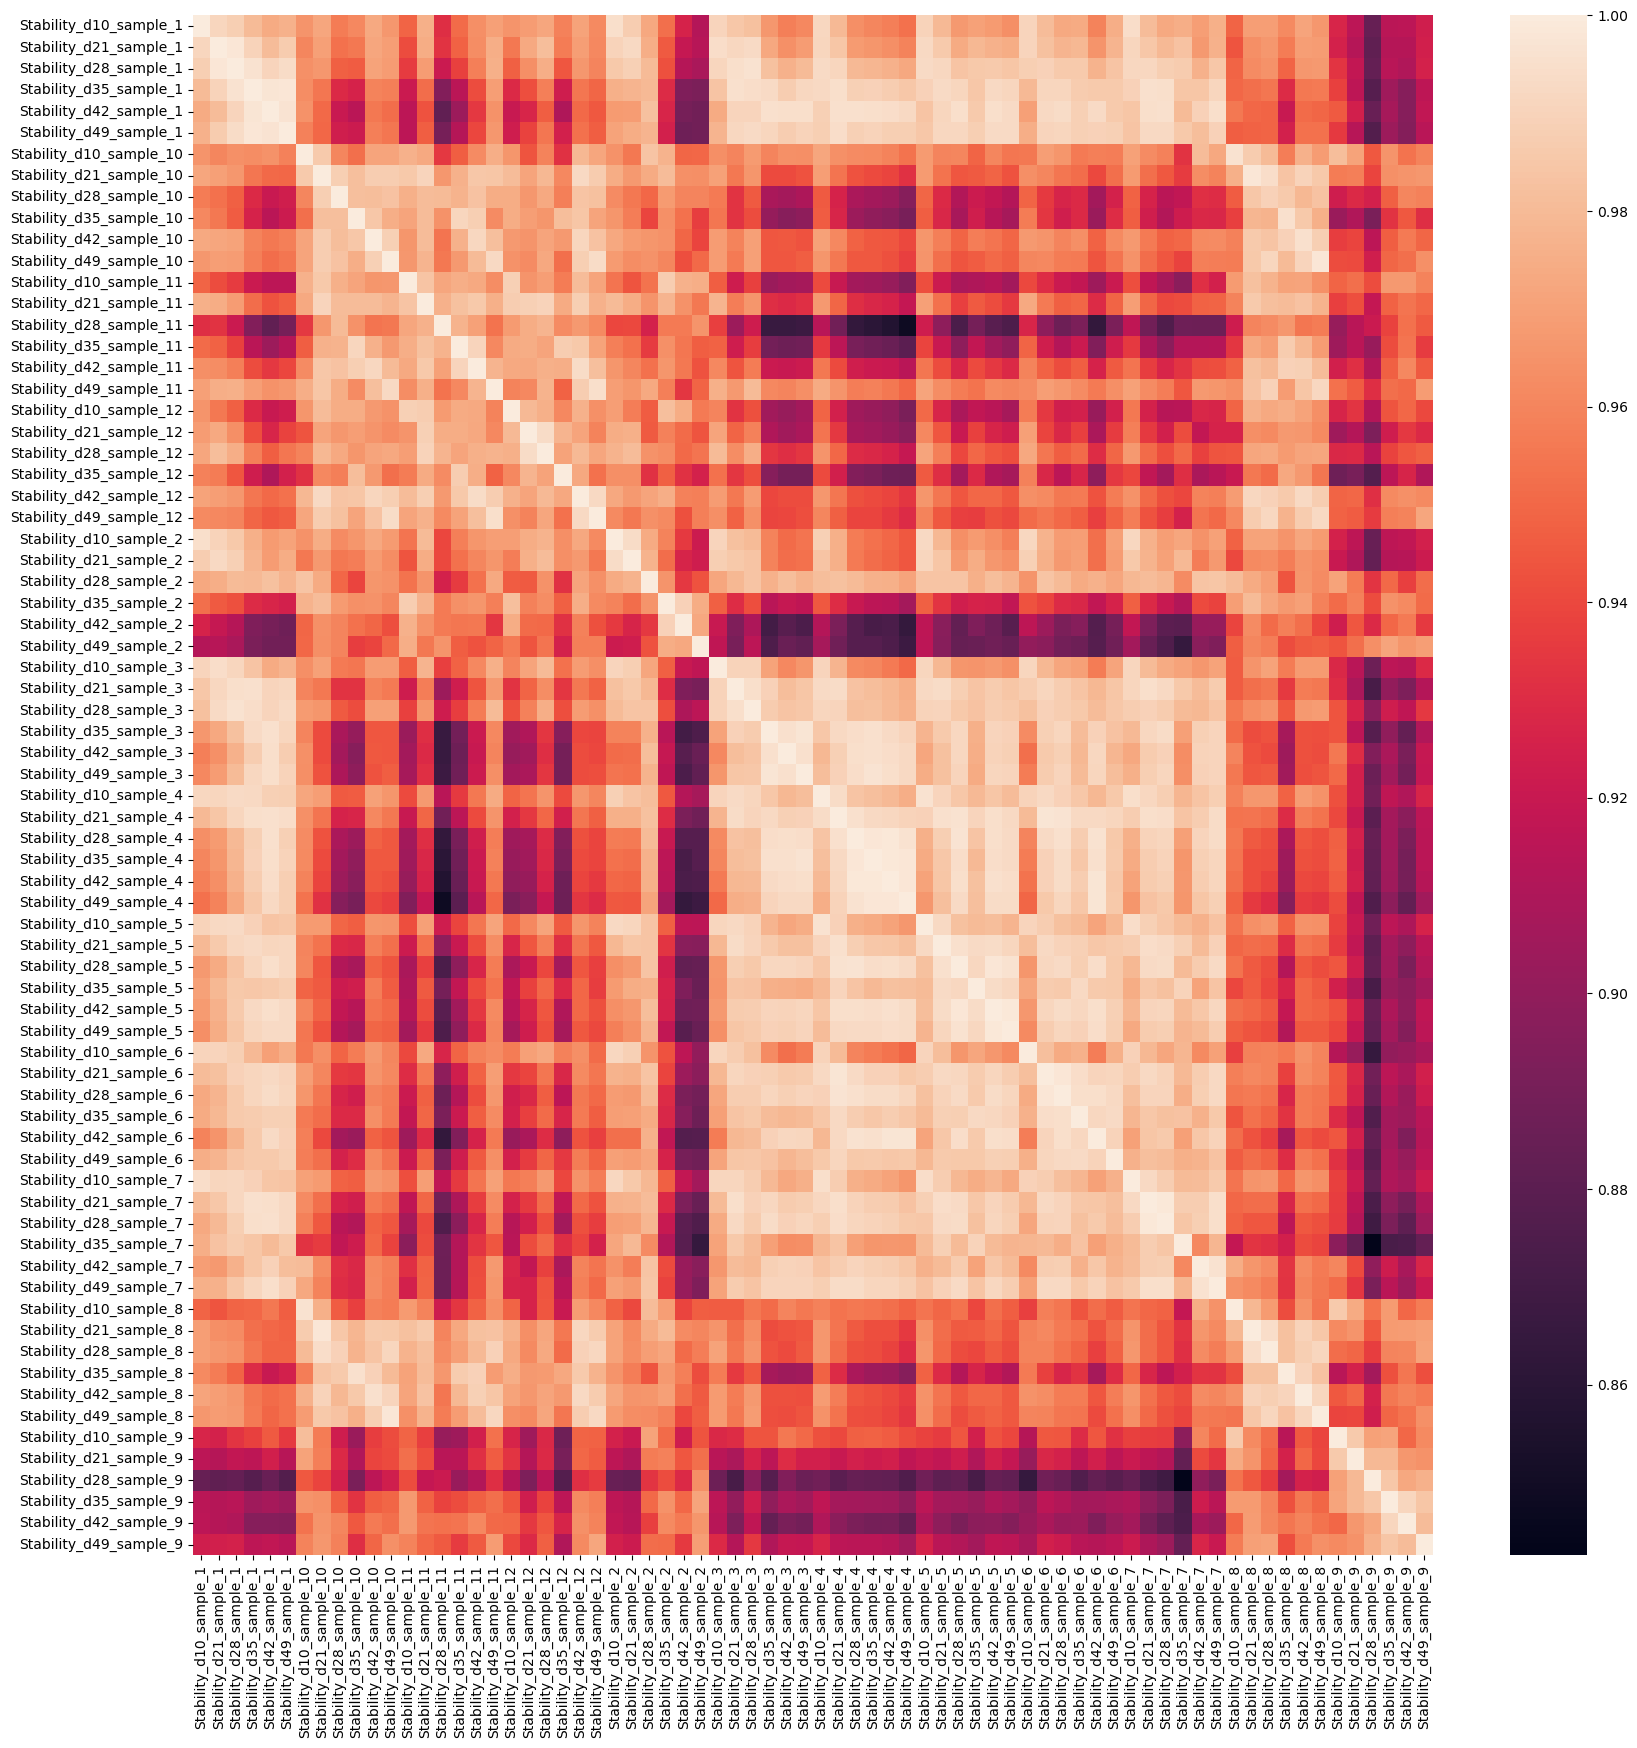

In [ ]:
# Final ordered correlation heatmap
if len(ordered_samples) > 0:
    print("Creating final ordered correlation heatmap...")
    
    plt.figure(figsize=(20, 20))
    
    # Create correlation matrix with ordered samples
    ordered_correlation = df_all_CPM.loc[var_genes, ordered_samples].corr()
    
    sns.heatmap(
        ordered_correlation,
        cmap='viridis',
        vmin=CORR_HEATMAP_VMIN,
        vmax=CORR_HEATMAP_VMAX,
        cbar_kws={'label': 'Pearson Correlation'}
    )
    
    plt.title('Sample Correlations (Ordered by Sample and Timepoint)', fontsize=16)
    plt.tight_layout()
    
    # Save final heatmap
    final_heatmap_file = os.path.join(PLOT_DIR, "samples_correlation_ordered_1000var_CPM.png")
    plt.savefig(final_heatmap_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"✓ Saved final correlation heatmap to {final_heatmap_file}")
    print(f"  Matrix size: {ordered_correlation.shape}")
else:
    print("⚠ No ordered samples available for final heatmap")

## 5. Summary and Session Information

In [ ]:
# Pipeline execution summary
print("="*60)
print("STABILITY DATA PROCESSING PIPELINE - COMPLETED")
print("="*60)

print(f"\n📊 Data Processing Summary:")
print(f"  • Processed {len(stability_experiments)} stability experiments")
print(f"  • Generated count matrix: {df_all.shape}")
print(f"  • Normalization: CPM (Counts Per Million)")
print(f"  • Variable genes analyzed: {N_VARIABLE_GENES}")

if reproducibility_available:
    print(f"  • Integrated with {len(selected_parse_exps)} reproducibility samples")
    print(f"  • Combined matrix: {df_all_parse.shape}")

print(f"\n📁 Output Files Generated:")
print(f"  • {OUTPUT_DIR}/stability_timepoints.tsv")
print(f"  • {OUTPUT_DIR}/stability_timepoints_meta.tsv")
if reproducibility_available:
    print(f"  • {OUTPUT_DIR}/stability_timepoints_wSC.tsv")
    print(f"  • {OUTPUT_DIR}/stability_timepoints_meta_wSC.tsv")

print(f"\n📈 Visualization Files Generated:")
print(f"  • {PLOT_DIR}/all_samples_correlation_heatmap.png")
print(f"  • {PLOT_DIR}/sample_correlations_grid.png")
print(f"  • {PLOT_DIR}/samples_correlation_ordered_1000var_CPM.png")
print(f"  • {PLOT_DIR}/sample_*_timepoints_corr_variablegenes.png (individual)")

if deseq2_available:
    print(f"  • {PLOT_DIR}/downregulated_genes_ranked.txt")
    print(f"  • {PLOT_DIR}/upregulated_genes_ranked.txt")

print(f"\n🔬 Session Information:")
print(f"  • Python version: {sys.version.split()[0]}")
print(f"  • Pandas version: {pd.__version__}")
print(f"  • NumPy version: {np.__version__}")
print(f"  • Matplotlib version: {mpl.__version__}")
print(f"  • Seaborn version: {sns.__version__}")
print(f"  • Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n✅ Pipeline completed successfully!")
print("Next steps: Use generated count matrices for downstream analysis (DESeq2, clustering, etc.)")

# Import sys for session info
import sys